In [1]:
#%reset
# import packages
import pandas as pd
pd.set_option("display.precision", 2)
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import seaborn as sns
import numpy as np
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import os
sns.set()
import re
warnings.filterwarnings('ignore')
from pylab import *
sns.set()
# pip3 install -U scikit-learn scipy matplotlib
def jitter(values,j):
    return values + np.random.normal(j,0.01,values.shape)
from PIL import Image, ImageDraw

In [5]:
# read data preprocessed in knime
df = pd.read_csv('../data/daint-data/data_20220901_toxclass.csv', encoding ='utf8' , engine='python')
df['model'] = df['model'].str.replace(" ", "")
df['fps'] = df['fps'].str.replace("RDkit", "RDKit")
df['fps_class'] = df['fps_class'].str.replace("RDkit", "RDKit")
df = df.drop(df[df['model'] == "NaiveBayes"].index)
df.rename(columns = {'sample':'subsampling', 'resample':'resampling'}, inplace = True)
vals_to_replace = {'rf':'tree', 'CSimca' :'simca', 'kernelpls':'pls', 'kknn':'knn', 'RRF':'tree', 'RandomForest':'tree', 
          'DecisionTree':'tree', 'adaboost':'boost-tree', 'AdaBag':'boost-tree', 'bayesglm':'linear', 'GeneralizedLinearModel(H2O)':'linear',
          'glmStepAIC':'linear', 'LogisticRegression':'linear', 'regLogistic':'linear', 'deepboost':'boost-tree', 'GradientBoostedTrees':'boost-tree',
          'XGBoostTrees':'xboost-tree', 'xgbTree':'xboost-tree', 'DeepLearning(Keras)':'deep', 'NeuralNetwork':'deep', 'pcaNNet':'deep',
          'glmnet':'deep', 'nnet':'deep', 'avNNet':'deep', 'svmPoly':'svm', 'gaussprRadial':'svm','svmRadialCost':'svm','svmRadialCost':'gaussian', 'gbm':'boost-tree'}
df['model'] = df['model'].map(vals_to_replace)

# add class info
df_class = pd.read_csv('../data/tox21-data/class_endpoint_mechtarget_reftable.csv', encoding ='utf8' , engine='python')
df_class.rename(columns = {'class_id':'class'}, inplace = True)
df_class['class'] = df_class['class'].str.replace("_", "")
df_class = df_class[['mechanisticTargets', 'mechT', 'class']]
df = pd.merge(df, df_class, on='class')
#df['mechT'] = df['mechT'].str.replace(" ", "")

df['mechT'] = df['mechT'].str.replace("GER Steroid Hormone Nuclear Rec.", "Steroid Hormone Rec.")
df['mechT'] = df['mechT'].str.replace("Gamma-Aminobutyric Acid Sign. Path.", "Aminobutyric Acid Path.")
df['mechT'] = df['mechT'].str.replace("CC-GER Fatty Acid Signaling", "Fatty Acid Signaling")
df['mechT'] = df['mechT'].str.replace("GER Developmental Sign.", "GER Dev. Sign.")
df['mechT'] = df['mechT'].str.replace("GER Glucocorticoid Met. Proc.", "Glucocorticoid Met. Proc.")

# create groups of data
df_daint = df[df['source'] == "daint"]
df_knime_oob= df[df['source'] == "knime-oob"]
df_knime_fb= df[df['source'] == "knime-fb"]
frames = [df_daint, df_knime_oob]
dff = pd.concat(frames)
dff.to_csv('../outputs/data_20220901_daint-knimeoob')
df_cytotox = df[df['cyto'] == 'yes']
df_nocytotox = df[df['cyto'] == "no"]
df_xboost = dff[dff['model'] == "xboost-tree"]
df_csi = dff[dff['fps_class'] == "CSI"]
dff.columns

# select winning configuration
df_wc = df.drop(df[df['sampling_independent'] == "no"].index)
df_wc = df_wc[df_wc['model'] == 'xboost-tree']
df_wc = df_wc[df_wc['subsampling'] == 'smote']
df_wc = df_wc[df_wc['resampling'] == 'repeatedcv']
df_wc = df_wc[df_wc['fps'] == 'CSI']
print(df_wc["class"].nunique())
print(df_wc["mechT"].nunique())
print(df_wc.shape)
df_wc_mechT_max = df_wc.groupby('mechT', as_index=False).max(['sensitivity', 'specificity', 'precision', 'F', 'cohen', 'accuracy'])
df_wc_mechT_cyto_mean = df_wc.groupby(['mechT','cyto'], as_index=False).mean() 
df_wc_mechT_cyto_max = df_wc.groupby(['mechT','cyto'], as_index=False).max()
df_wc_mechT_cyto_mean["metric"] = "mean"
df_wc_mechT_cyto_max["metric"] = "max"
frames2 = [df_wc_mechT_cyto_max, df_wc_mechT_cyto_mean]
df_wc_mechT_2 = pd.concat(frames2)
df_wc_mechT_2.groupby("mechT").count()
df_wc_mechT_2.head(5)
# create groupings
dff_mechT_mean = dff.groupby(['mechT','fps_class','model', 'cyto'], as_index=False).mean()
dff_mechT_max = dff.groupby(['mechT','fps_class','model', 'cyto'], as_index=False).max()
dff_assay_max = dff.groupby(['mechT','class'], as_index=False).max()
dff_assay_mean = dff.groupby(['mechT','class'], as_index=False).mean()
dff_assay_max.shape

218
33
(870, 17)


(576, 17)

In [32]:
dff_mechT_mean.head()
dff_mechT_mean.columns

Index(['mechT', 'fps_class', 'model', 'cyto', 'sensitivity', 'specificity',
       'precision', 'F', 'accuracy', 'cohen'],
      dtype='object')

In [47]:
df_corr = df_final_target.drop(['ctb', 'hitc_perc', 'aeid_unique#', 'hitc_count'], axis=1)
df_corr = df_corr.rename(columns={'hitc_sum': 'hitc1%', 'DTXSID_unique#': 'DTXSID#'})
corr = df_corr.corr()
corr.style.background_gradient(cmap="RdYlGn")
plt.savefig('../plots/knime/correlation_of_metrics.png', bbox_inches = 'tight')

<Figure size 1440x720 with 0 Axes>

['ANG' 'AR' 'ARO' 'CC' 'CP' 'CVP' 'DNA' 'DP' 'EM' 'EMP' 'ER' 'FAS' 'GLC'
 'HM' 'IR' 'MOA' 'OS' 'PRG' 'TF' 'ThR' 'XM' 'XR' 'p53']
['ANG' 'AR' 'ARO' 'CC' 'CP' 'CVP' 'DNA' 'DP' 'EM' 'EMP' 'ER' 'FAS' 'GLC'
 'HM' 'IR' 'MOA' 'OS' 'PRG' 'TF' 'ThR' 'XM' 'XR' 'p53']


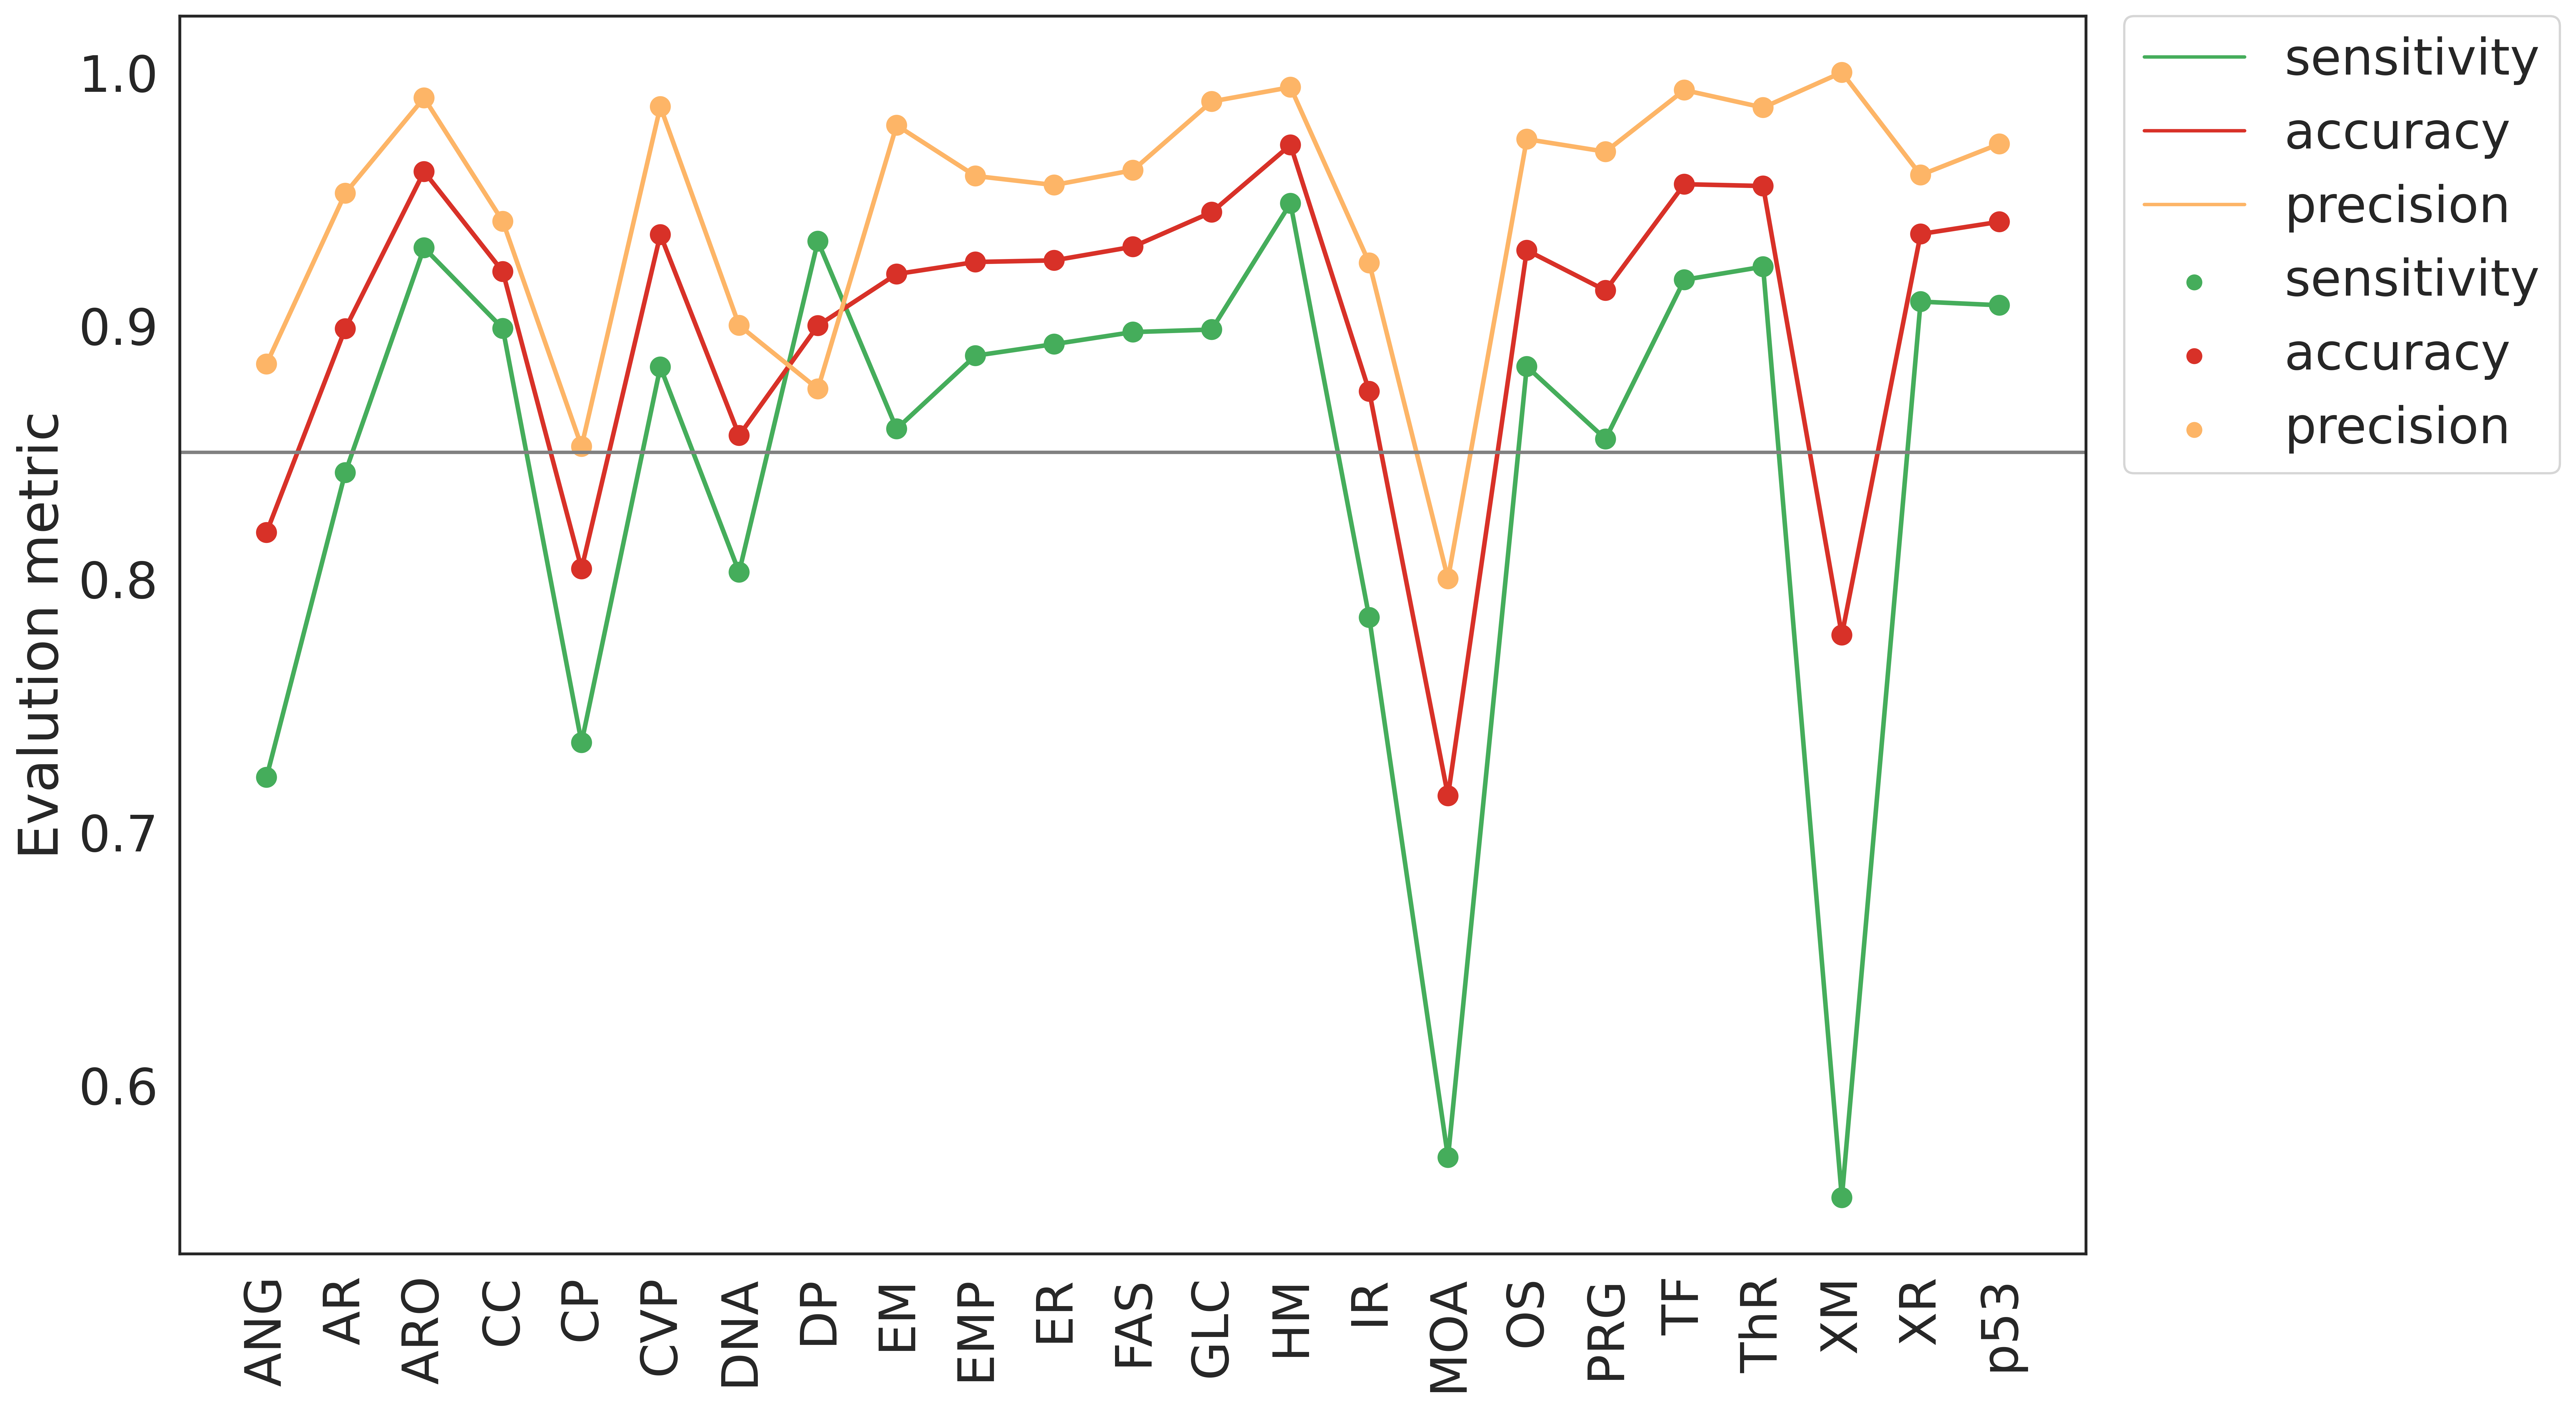

In [18]:
mechs_to_replace = {'Androgen Met. Proc.':'AR',
                    'Angiogenic Proc.' :'ANG',
                    'Aromatase Act.':'ARO',
                    'CC-GER Developmental Sign.':'DS',
                    'CC-GER Inflammatory Resp.':'IR',
                    'CC-GER Oxidative Stress':'OS',
                    'CC-GER Transcription Fact.':'TF',
                    'Cell Cycle':'CC',
                    'Cell Viability Proc.':'CVP',
                    'Coagulation Proc.':'CP',
                    'DNA Damage':'DNA',
                    'Dopamine Rec. Sign. Path.':'DP',
                    'Energy Met. Proc.':'EMP',
                    'Estrogen Met. Proc.':'ER',
                    'Extracellular Matrix':'EM',
                    'GER Developmental Sign.':'DS',
                    'GER Estrogen Met. Proc.':'ER',
                    'GER Fatty Acid Sign.':'FAS',
                    'GER Glucocorticoid Met. Proc.':'GLC',
                    'GER Oxidative Stress':'OS',
                    'GER Progesterone Met. Proc.':'PRG',
                    'GER Steroid Hormone Nuclear Rec.':'StH',
                    'GER Thyroid Rec. Sign.':'ThR',
                    'GER Transcription Factors':'TF',
                    'GER Xenobiotic Resp.':'XR',
                    'Glucocorticoid Met. Proc.':'GLC',
                    'Histone Modification':'HM',
                    'Inflammatory Resp.':'IR',
                    'Monoamine Oxidase Act.':'MOA',
                    'Progesterone Met. Proc.':'PRG',
                    'Thyrotropin Rec. Act.':'ThR',
                    'UNA':'UNA',
                    'Xenobiotic Metab.':'XM',
                    'p53 Sign. Path.':'p53'}
df_wc_mechT_cyto_mean2 = df_wc_mechT_cyto_mean.drop(df_wc_mechT_cyto_mean[df_wc_mechT_cyto_mean['mechT'] == "UNA"].index)
df_wc_mechT_cyto_mean2['mechTT'] = df_wc_mechT_cyto_mean2['mechT'].map(mechs_to_replace)
df_wc_mechT_cyto_mean2 = df_wc_mechT_cyto_mean2.groupby("mechTT", as_index=False).mean()

df_wc_mechT_cyto_melted = pd.melt(df_wc_mechT_cyto_mean2, 
   id_vars = ['mechTT'], 
   value_vars = ['sensitivity', 'accuracy', 'precision'], 
   var_name = 'Metrics', 
   value_name = 'Value',
   ignore_index = False)

%config InlineBackend.figure_format = 'retina'
sns.set(font_scale = 2)
sns.set_style("white")
rc = {'figure.figsize':(21,10),
      'axes.facecolor':'white',
      'axes.grid' : False,
      'grid.color': '.8',
      'font.size' : 22}
plt.rcParams.update(rc)
plt.figure(figsize=(15,10), dpi= 300)
sns.set_style("white")
palette = {"sensitivity":"tab:cyan",
           "precision":"tab:orange", 
           "accuracy":"tab:purple"}

palette2 = {"sensitivity":"#45ad5b",
           "precision":"#fdb567", 
           "accuracy":'#d83128'}

g = sns.lineplot(data=df_wc_mechT_cyto_melted, x='mechTT', y='Value', hue='Metrics', palette=palette2, linewidth=2)
g = sns.scatterplot(data=df_wc_mechT_cyto_melted, x='mechTT', y='Value', hue='Metrics',  palette = palette2, s=100)
plt.xticks(rotation=90)
g.axhline(0.85, color = "gray")
g.set(xlabel='', ylabel='Evalution metric')
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0) 
plt.savefig('../plots/knime/lineplot_datafinal_sens-vs-precision_16.svg', bbox_inches = 'tight', dpi = 300)
#plt.xticks(np.arange(min(x), max(x)+1), 1.0)


array(['ANG', 'AR', 'ARO', 'CC', 'CP', 'CVP', 'DNA', 'DP', 'EM', 'EMP',
       'ER', 'FAS', 'GLC', 'HM', 'IR', 'MOA', 'OS', 'PRG', 'TF', 'ThR',
       'XM', 'XR', 'p53', nan], dtype=object)

<Figure size 3900x3000 with 0 Axes>

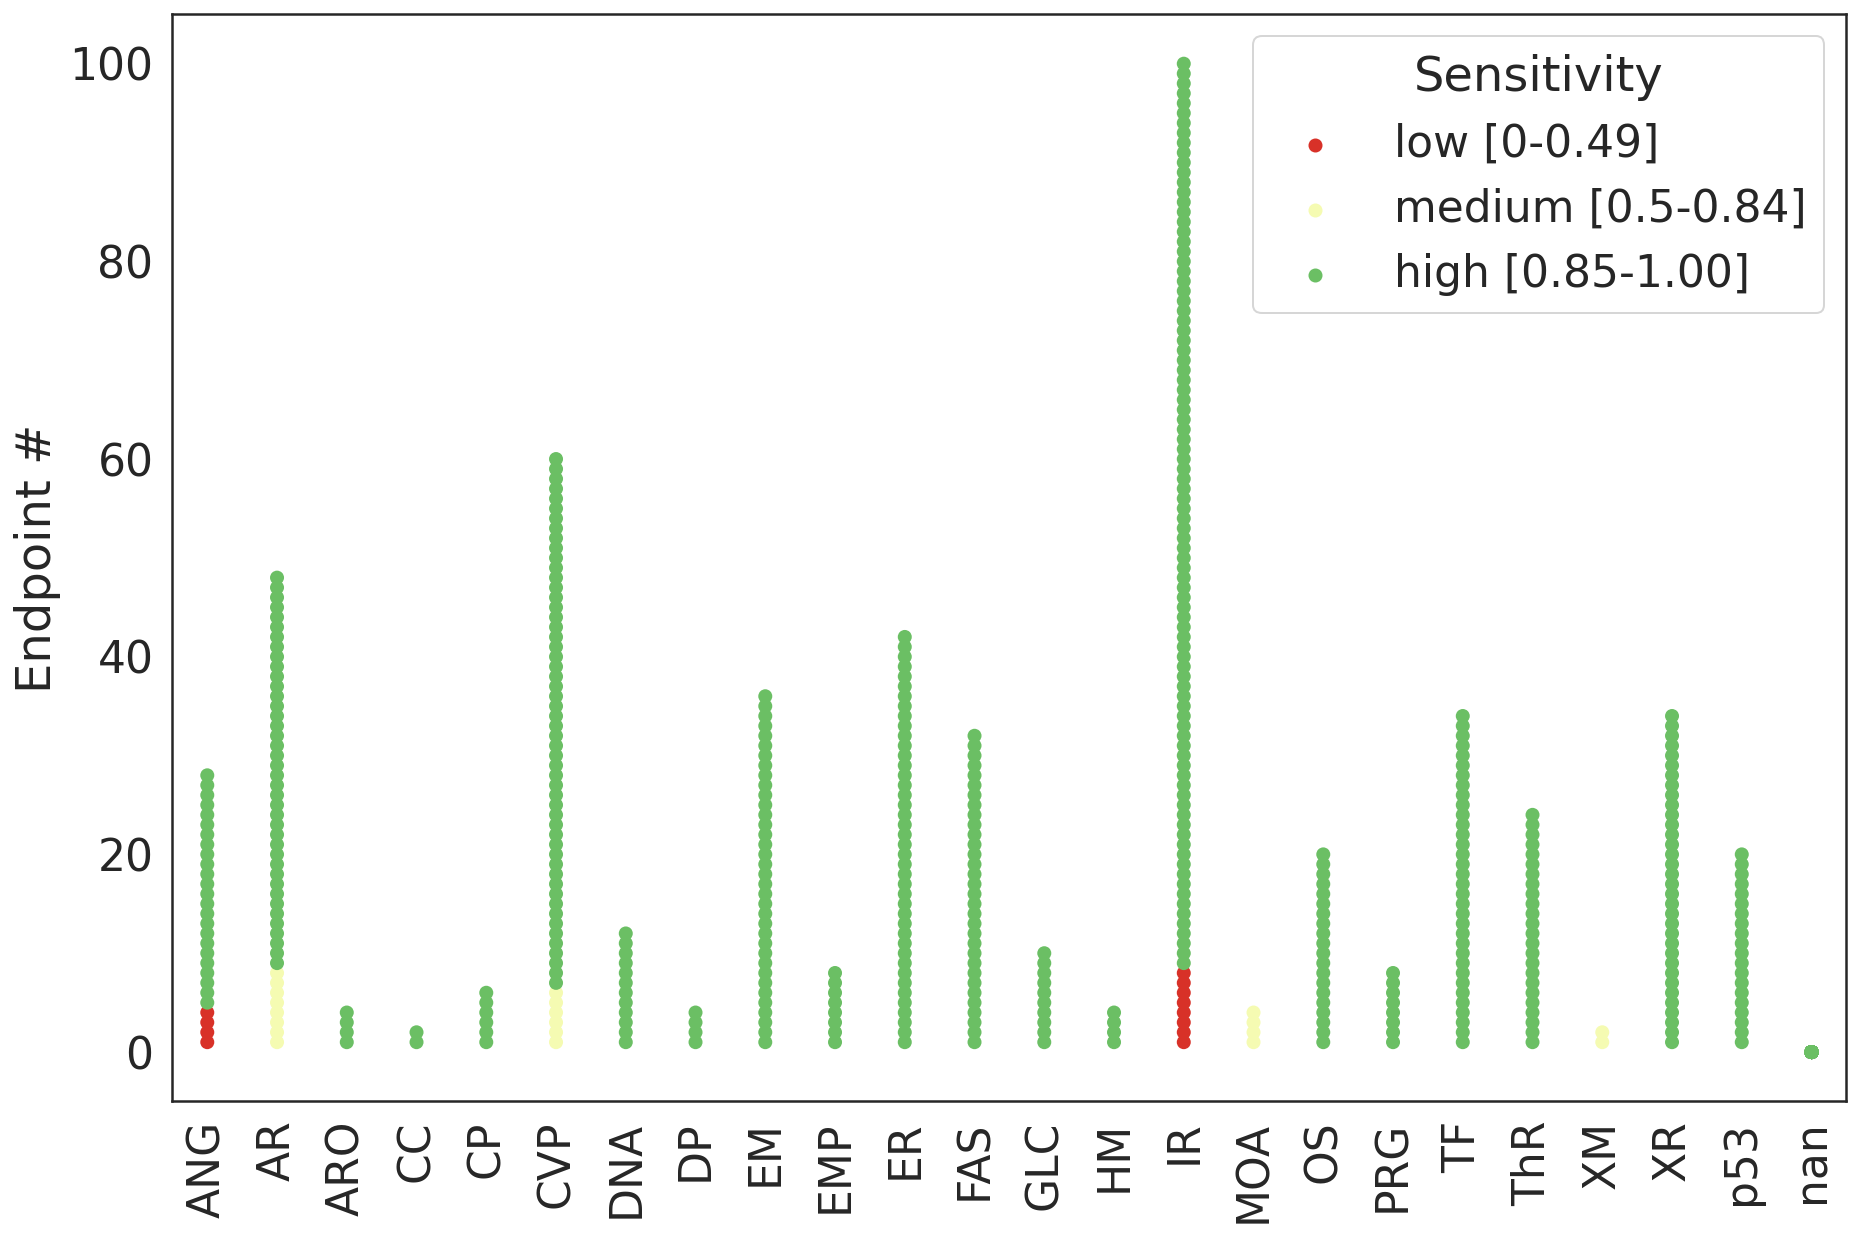

In [22]:
%config InlineBackend.figure_format = 'retina'
sns.set(font_scale = 2)
sns.set_style("white")
rc = {'figure.figsize':(20,10),
      'axes.facecolor':'white',
      'axes.grid' : False,
      'grid.color': '.8',
      'font.size' : 22}
plt.rcParams.update(rc)
plt.figure(figsize=(13,10), dpi= 300)
sns.set_style("white")
palette3 = {"0.0-0.49":'#d83128',"0.5-0.84":"#f5fbb2", "0.85-1.0":"#6bbf64"}

df_wc_dot = df_wc.sort_values(by=['sensitivity'])
df_wc_dot = df_wc_dot.drop(df_wc_dot[df_wc_dot['mechT'] == "UNA"].index)

df_wc_dot['mechTT'] = df_wc_dot['mechT'].map(mechs_to_replace)

mechTT_count = []
#print(mechTT_count)

for index, mechTT in enumerate(df_wc_dot['mechTT']):
    subset = df_wc_dot.iloc[:index + 1] 
    count = len(subset[subset['mechTT'] == mechTT])
    mechTT_count.append(count) 
#print(mechTT_count)

df_wc_dot['sensitivity_discrete'] = pd.cut(df_wc_dot.sensitivity, bins=3, labels=['0.0-0.49', '0.5-0.84', '0.85-1.0'], right=False)
# Data for the plot
x = df_wc_dot['mechTT']
y = mechTT_count
hue = df_wc_dot['sensitivity_discrete']
sns.set_style("white")
# Dot plot created using scatter plot
plt.figure(figsize=(15, 10))
order = df_wc_dot.mechTT.sort_values().unique()
ax = sns.stripplot(x=x, y=y, hue=hue, s=7, legend="full", palette=palette3, order = order, jitter=False, edgecolor = "gray")
ax.set(xlabel='', ylabel='Endpoint #')
plt.xticks(rotation=90)
legend_labels, _= ax.get_legend_handles_labels()
ax.legend(legend_labels, ['low [0-0.49]','medium [0.5-0.84]','high [0.85-1.00]'], 
          bbox_to_anchor=(1,1), 
          title='Sensitivity')
plt.savefig('../plots/knime/dotplot_datafinal_endpointspermech_strip.svg', bbox_inches = 'tight', dpi = 300)
df_wc_dot.mechTT.sort_values().unique()

In [108]:
df_wc.groupby('mechT').count()

,sensitivity,specificity,precision,F,class,fps,model,subsampling,resampling,cyto,source,sampling_independent,accuracy,cohen,fps_class,mechanisticTargets
mechT,,,,,,,,,,,,,,,,
Androgen Met. Proc.,48,48,48,48,48,48,48,48,48,48,48,48,48,48,48,48
Angiogenic Proc.,28,28,28,28,28,28,28,28,28,28,28,28,28,28,28,28
Aromatase Act.,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4
CC-GER Dev. Sign.,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2
CC-GER Inflammatory Resp.,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4
CC-GER Oxidative Stress,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2
CC-GER Transcription Fact.,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10
Cell Cycle,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2
Cell Viability Proc.,60,60,60,60,60,60,60,60,60,60,60,60,60,60,60,60
